In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 11s 0us/step


In [5]:
train_dir = os.path.join(dataset_dir, 'train')
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [40]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.15, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 21250 files for training.


In [41]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [42]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [43]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [44]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [45]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [46]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [47]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [51]:
embedding_dim = 32

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.25),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.25),
  layers.Dense(1)])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320032    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 32)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 320,065
Trainable params: 320,065
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [53]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
665/665 [==============================] - 5s 6ms/step - loss: 0.6759 - binary_accuracy: 0.6216 - val_loss: 0.5661 - val_binary_accuracy: 0.7776
Epoch 2/10
665/665 [==============================] - 4s 5ms/step - loss: 0.5221 - binary_accuracy: 0.8042 - val_loss: 0.4257 - val_binary_accuracy: 0.8444
Epoch 3/10
665/665 [==============================] - 4s 5ms/step - loss: 0.3973 - binary_accuracy: 0.8559 - val_loss: 0.3566 - val_binary_accuracy: 0.8668
Epoch 4/10
665/665 [==============================] - 4s 5ms/step - loss: 0.3322 - binary_accuracy: 0.8781 - val_loss: 0.3202 - val_binary_accuracy: 0.8766
Epoch 5/10
665/665 [==============================] - 4s 5ms/step - loss: 0.2929 - binary_accuracy: 0.8945 - val_loss: 0.2979 - val_binary_accuracy: 0.8846
Epoch 6/10
665/665 [==============================] - 4s 6ms/step - loss: 0.2650 - binary_accuracy: 0.9033 - val_loss: 0.2828 - val_binary_accuracy: 0.8880
Epoch 7/10
665/665 [==============================] - 4s 6ms/ste

In [54]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 13s 16ms/step - loss: 0.3084 - binary_accuracy: 0.8732
Loss:  0.30836057662963867
Accuracy:  0.873199999332428


In [55]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

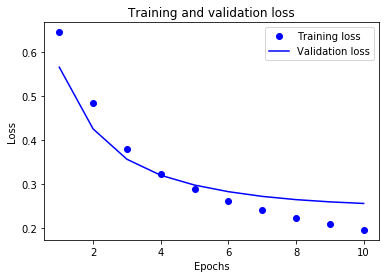

In [56]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

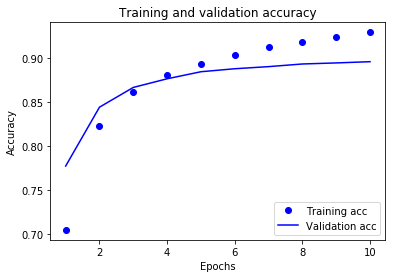

In [57]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [60]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 15s 19ms/step - loss: 0.3147 - accuracy: 0.8706
0.873199999332428


In [64]:
examples = [
  "I will buy Dogecoin for my son!",
    "Ether is just terrible"
]

export_model.predict(examples)

array([[0.6772402],
       [0.3807223]], dtype=float32)